# 💪Laboratorio 3: Registro y análisis de señales EMG de superficie usando BITalino
---
## 📖1. Introducción
---
La electromiografía de superficie (sEMG) es una técnica no invasiva que permite registrar la actividad eléctrica generada por el sistema músculo esquelético. Su señal surge de la activación de múltiples unidades motoras (UM), cada una conformada por una motoneurona y las fibras musculares que inerva. Cuando un potencial de acción alcanza la unión neuromuscular, la liberación de acetilcolina desencadena la despolarización de las fibras, cuyo impulso se propaga bidireccionalmente a lo largo de ellas. Estas contribuciones eléctricas se suman en la superficie cutánea y conforman los potenciales de acción de unidad motora (MUAPs), cuya superposición temporal y espacial da origen a la señal sEMG, reflejando la organización y el control del sistema neuromuscular [1]. 

Desde el punto de vista clínico, la sEMG proporciona información esencial sobre el reclutamiento de unidades motoras, la frecuencia de descarga y la coordinación neuromuscular, lo que la convierte en una herramienta valiosa para estudiar tanto el funcionamiento fisiológico como las alteraciones patológicas del sistema motor. Recientes investigaciones destacan su utilidad en la rehabilitación neuromuscular, la monitorización de la fatiga y el control de prótesis o interfaces hombre-máquina [2], [3]. Por su carácter no invasivo y su capacidad de ofrecer datos en tiempo real, la sEMG se ha consolidado como una técnica fundamental en fisiología aplicada y en la práctica clínica moderna.

## 🎯2. Objetivo del laboratorio
---
## 🧰3. Materiales
---
## 🧪4. Procedimiento
---
## 📊5. Resultados
---
## 📝6. Conclusiones
---
## 📚7. Referencias
---
## 📂8. Anexos
---

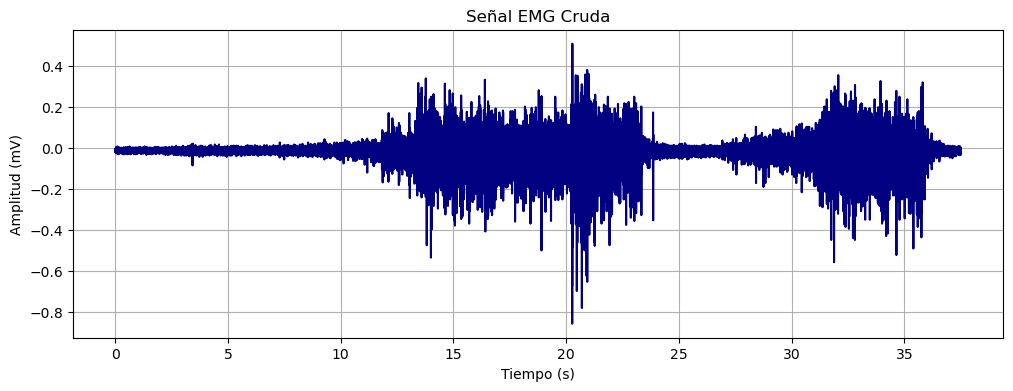

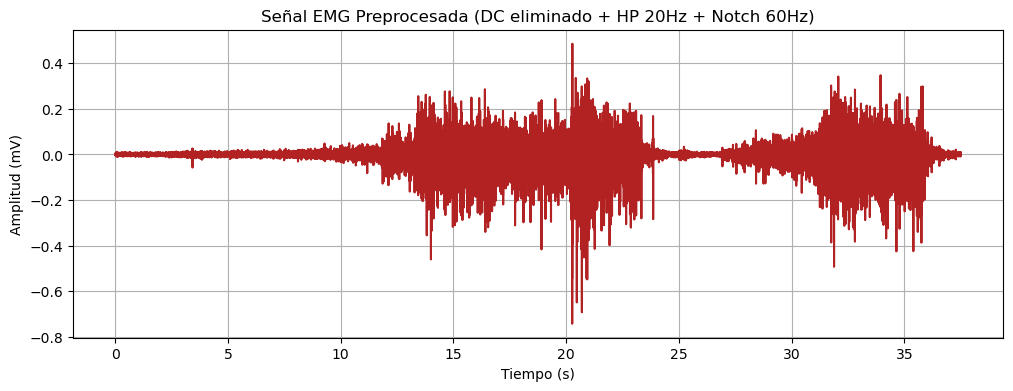

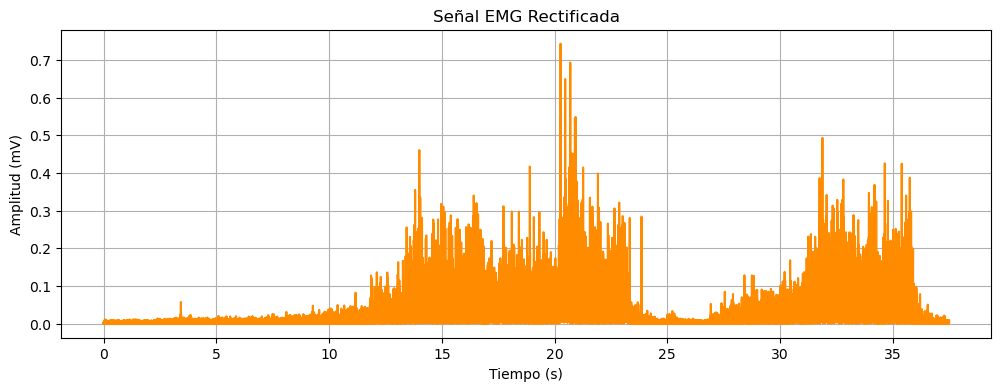

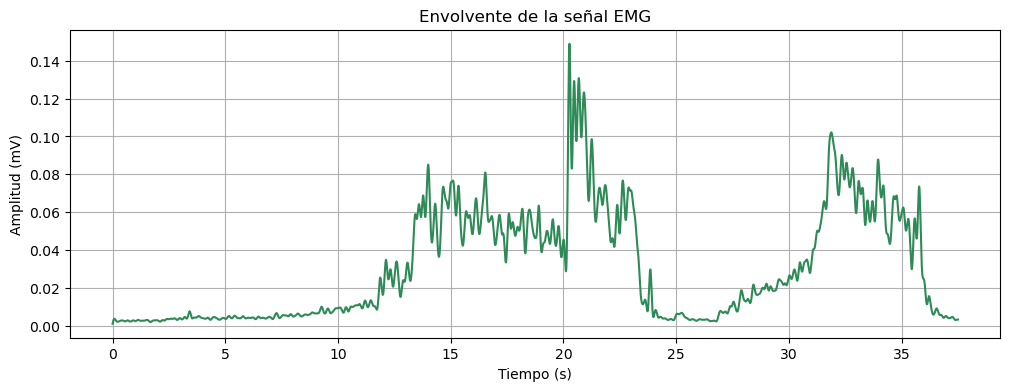

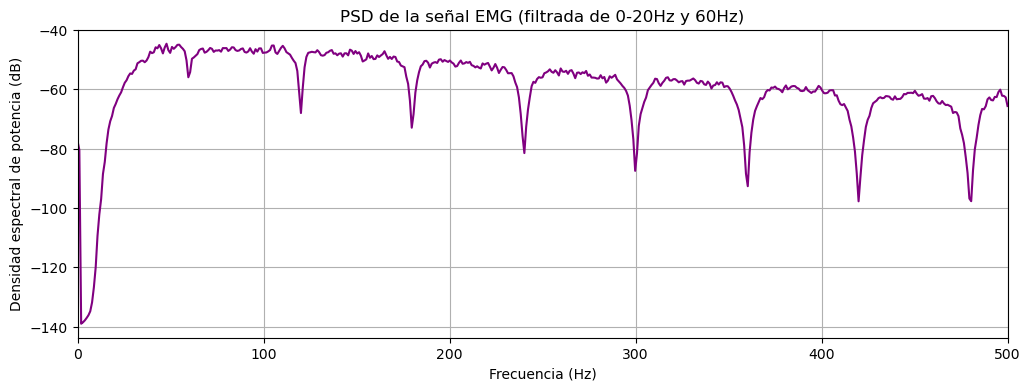

Frecuencias de picos detectados (Hz): [ 35.15625    39.0625     41.9921875  43.9453125  47.8515625  50.78125
  54.6875     67.3828125  71.2890625  74.21875    76.171875   78.125
  80.078125   83.0078125  88.8671875  92.7734375  95.703125   98.6328125
 105.46875   110.3515625 125.9765625 128.90625   136.71875   138.671875
 141.6015625 144.53125   146.484375  149.4140625 151.3671875 156.25
 158.203125  161.1328125 165.0390625 167.96875   169.921875  187.5
 192.3828125 195.3125    197.265625  200.1953125 206.0546875 208.984375
 210.9375    214.84375   217.7734375 220.703125  224.609375  228.515625
 259.765625 ]


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, find_peaks

# === 1. Leer archivo de EMG ===
ruta = r"C:\SeñalesLab3\Lento2Flexor.txt"
df = pd.read_csv(ruta, sep="\t", comment="#",
                 names=["nSeq", "I1", "I2", "O1", "O2", "A1"])

# === 2. Extraer canal O2 ===
ADC = df["O2"].values  # Canal de interés

# === 3. Parámetros del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000  # Frecuencia de muestreo en Hz

# === 4. Conversión ADC → mV ===
EMG_V = ((ADC / ADCres) - 0.5) * VCC / Gain  # Señal en volts
EMG_mV = EMG_V * 1000  # Convertir a mV

# === 5. Quitar componente DC ===
EMG_noDC = EMG_mV - EMG_mV.mean()  # Centrar la señal alrededor de 0

# === 6. Filtro pasa-altas 20 Hz ===
fc = 20  # Frecuencia de corte en Hz
b, a = signal.butter(4, fc/(fs/2), btype='high')  # Butterworth 4º orden
EMG_filtered = signal.filtfilt(b, a, EMG_noDC)  # Filtrado sin desfase

# === 6b. Filtro notch 60 Hz y armónicos hasta 480 Hz ===
EMG_clean = EMG_filtered.copy()
Q = 30  # Factor de calidad para notch (estrecho)
for f_h in np.arange(60, 481, 60):  # 60, 120, 180, ..., 480 Hz
    b_notch, a_notch = signal.iirnotch(f_h, Q, fs)
    EMG_clean = signal.filtfilt(b_notch, a_notch, EMG_clean)  # Aplicar notch

# === 7. Vector de tiempo ===
t = np.arange(len(EMG_clean)) / fs  # Tiempo en segundos

# === 8. Graficar señal cruda ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_mV, color='navy')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Cruda")
plt.grid(True)
plt.show()

# === Graficar señal preprocesada (DC eliminado + HP + Notch) ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_clean, color='firebrick')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Preprocesada (DC eliminado + HP 20Hz + Notch 60Hz)")
plt.grid(True)
plt.show()

# === 9. Rectificación de la señal ===
EMG_rect = np.abs(EMG_clean)  # Valor absoluto para eliminar negativas
plt.figure(figsize=(12,4))
plt.plot(t, EMG_rect, color='darkorange')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Rectificada")
plt.grid(True)
plt.show()

# === 10. Calcular envolvente con filtro pasa-bajo 5 Hz ===
fc_env = 5  # Frecuencia de corte para suavizar la señal
b_env, a_env = signal.butter(4, fc_env/(fs/2), btype='low')
EMG_envelope = signal.filtfilt(b_env, a_env, EMG_rect)
plt.figure(figsize=(12,4))
plt.plot(t, EMG_envelope, color='seagreen')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Envolvente de la señal EMG")
plt.grid(True)
plt.show()

# === 11. PSD (densidad espectral de potencia) en dB usando Welch ===
f_psd, Pxx = welch(EMG_clean, fs=fs, nperseg=1024)  # PSD de la señal filtrada
Pxx_dB = 10 * np.log10(Pxx)  # Convertir a dB

# === Detectar picos en la PSD (opcional) ===
peaks, _ = find_peaks(Pxx_dB, height=np.mean(Pxx_dB)+6)

# === Graficar PSD en dB ===
plt.figure(figsize=(12,4))
plt.plot(f_psd, Pxx_dB, color='purple')  # Solo línea de PSD
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral de potencia (dB)")
plt.title("PSD de la señal EMG (filtrada de 0-20Hz y 60Hz)")
plt.xlim(0, 500)
plt.grid(True)
plt.show()

# === Mostrar frecuencias de picos detectados ===
print("Frecuencias de picos detectados (Hz):", f_psd[peaks])
